In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import cv2

# Function to apply CLAHE
def apply_clahe(image):
    image = np.array(image)
    if len(image.shape) == 3:  # Convert RGB to grayscale if necessary
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    return Image.fromarray(image)

# Transformation pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),  # Apply CLAHE
    transforms.Grayscale(num_output_channels=3),      # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),                    # Resize to 224x224
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.4609, 0.4609, 0.4609],
                         std=[0.2939, 0.2939, 0.2939]),  # Normalize
])

# Helper function to process a single image
def process_image(image_path, label):
    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image)
        return image_tensor, label
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# Multithreaded preprocessing and saving function
def preprocess_and_save_dataset(dataset_path, save_dir, split_ratios=(0.8, 0.1, 0.1), num_threads=24):
    image_paths = []
    labels = []

    # Collect image paths and labels
    for class_idx, class_folder in enumerate(os.listdir(dataset_path)):
        class_folder_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_folder_path):
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                image_paths.append(image_path)
                labels.append(class_idx)

    # Split dataset into train, validation, and test sets
    total_size = len(image_paths)
    train_size = int(split_ratios[0] * total_size)
    val_size = int(split_ratios[1] * total_size)
    test_size = total_size - train_size - val_size

    dataset = list(zip(image_paths, labels))
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    def process_and_save(data, filename):
        tensors = {"images": [], "labels": []}
        
        # Use multithreading to process images
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(process_image, image_path, label) for image_path, label in data]
            
            for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {filename}"):
                image_tensor, label = future.result()
                if image_tensor is not None:
                    tensors["images"].append(image_tensor)
                    tensors["labels"].append(label)

        # Stack tensors and save
        tensors["images"] = torch.stack(tensors["images"])
        tensors["labels"] = torch.tensor(tensors["labels"])
        torch.save(tensors, filename)
        print(f"Saved {filename} with {len(data)} samples.")

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Save train, validation, and test datasets
    process_and_save(train_data, os.path.join(save_dir, "train_data.pth"))
    process_and_save(val_data, os.path.join(save_dir, "val_data.pth"))
    process_and_save(test_data, os.path.join(save_dir, "test_data.pth"))

# Path to dataset
dataset_path = "//home/ai-user/Abhijay/Class_dataset"
save_dir = "processed_data"

# Preprocess and save dataset
preprocess_and_save_dataset(dataset_path, save_dir)


Processing processed_data/train_data.pth:  37%|███▋      | 17564/47250 [12:05<20:25, 24.22it/s]


In [8]:
import os
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import cv2
from torch.utils.data import DataLoader
import torch # type: ignore
from torch.utils.data import DataLoader # type: ignore
import os
import cv2 # type: ignore
import numpy as np # type: ignore
from PIL import Image # type: ignore
from torchvision import models, transforms # type: ignore
from torch.utils.data import DataLoader, Dataset, random_split # type: ignore
from tqdm import tqdm # type: ignore
import torch.optim as optim # type: ignore
import torch.nn as nn # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # type: ignore




In [6]:
save_dir = "processed_data"

# Load processed datasets
def load_processed_dataset(save_dir):
    train_data = torch.load(os.path.join(save_dir, "train_data.pth"))
    val_data = torch.load(os.path.join(save_dir, "val_data.pth"))
    test_data = torch.load(os.path.join(save_dir, "test_data.pth"))
    return train_data, val_data, test_data

# Load the datasets
train_data, val_data, test_data = load_processed_dataset(save_dir)

# Create DataLoaders
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = TensorDataset(train_data["images"], train_data["labels"])
val_dataset = TensorDataset(val_data["images"], val_data["labels"])
test_dataset = TensorDataset(test_data["images"], test_data["labels"])

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=24,prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=24,prefetch_factor=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=24,prefetch_factor=2)


/tmp/ipykernel_6811/2956610174.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train_data.pth"))


/tmp/ipykernel_6811/2956610174.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_data = torch.load(os.path.join(save_dir, "val_data.pth"))
/tmp/ipykernel_6811/29566101

In [9]:
# Define a combined model that uses DenseNet121 and EfficientNet B3 (from torchvision)
class CombinedModel(nn.Module):
    def __init__(self, num_classes=1):
        super(CombinedModel, self).__init__()

        # Load DenseNet121 model
        self.densenet = models.densenet121(pretrained=True)
        self.densenet_features = self.densenet.features  # Get DenseNet feature extractor
        self.densenet_fc_in_features = self.densenet.classifier.in_features  # Get input features for DenseNet classifier
        self.densenet.classifier = nn.Identity()  # Remove DenseNet classifier
        
        # Load EfficientNet B3 model from torchvision
        self.efficientnet = models.efficientnet_b3(pretrained=True)  # EfficientNet B3 from torchvision
        self.efficientnet_fc_in_features = self.efficientnet.classifier[1].in_features  # Get input features for EfficientNet classifier
        self.efficientnet.classifier = nn.Identity()  # Remove EfficientNet classifier

        # Combined feature map size after concatenation
        self.fc_in_features = self.densenet_fc_in_features + self.efficientnet_fc_in_features
        
        # Final classifier (After feature concatenation)
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 512),  # Concatenate features and pass to fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        # Extract features from both models
        densenet_features = self.densenet(x)
        efficientnet_features = self.efficientnet(x)

        # Concatenate the features from both models
        combined_features = torch.cat((densenet_features, efficientnet_features), dim=1)  # Concatenate along the feature dimension

        # Pass the concatenated features through the final classifier
        out = self.fc(combined_features)
        return out

# Instantiate the model
model = CombinedModel(num_classes=1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function: Binary Cross-Entropy
criterion = nn.BCELoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)




/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /home/ai-user/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:10<00:00, 4.83MB/s]


In [11]:
# Training loop
num_epochs = 10  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training step
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
    
    # Print the loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataloader):.4f}")
    
    # Validation step after each epoch
    model.eval()
    correct_preds = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images)
            preds = (outputs.squeeze() > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_preds / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Calculate and print metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")

# Save the combined model
torch.save(model.state_dict(), "combined_model_new.pth")
print("Combined model saved as 'combined_model_new.pth'")



Epoch 1/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.28it/s]

Epoch 1/10, Loss: 0.0522


Validation Accuracy: 98.41%
Precision: 0.9909
Recall: 0.9854
F1 Score: 0.9881
Confusion Matrix:
[[1904   36]
 [  58 3908]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 2/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 2/10, Loss: 0.0392


Validation Accuracy: 98.46%
Precision: 0.9874
Recall: 0.9897
F1 Score: 0.9885
Confusion Matrix:
[[1890   50]
 [  41 3925]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 3/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/10: 100%|██████████| 1477/1477 [03:56<00:00,  6.25it/s]

Epoch 3/10, Loss: 0.0244


Validation Accuracy: 98.36%
Precision: 0.9896
Recall: 0.9859
F1 Score: 0.9877
Confusion Matrix:
[[1899   41]
 [  56 3910]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 4/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 4/10, Loss: 0.0186


Validation Accuracy: 98.34%
Precision: 0.9884
Recall: 0.9869
F1 Score: 0.9876
Confusion Matrix:
[[1894   46]
 [  52 3914]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 5/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 5/10, Loss: 0.0149


Validation Accuracy: 97.76%
Precision: 0.9900
Recall: 0.9766
F1 Score: 0.9832
Confusion Matrix:
[[1901   39]
 [  93 3873]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      1940
         1.0       0.99      0.98      0.98      3966

    accuracy                           0.98      5906
   macro avg       0.97      0.98      0.97      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 6/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 6/10, Loss: 0.0114


Validation Accuracy: 98.09%
Precision: 0.9883
Recall: 0.9831
F1 Score: 0.9857
Confusion Matrix:
[[1894   46]
 [  67 3899]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1940
         1.0       0.99      0.98      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 7/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 7/10, Loss: 0.0104


Validation Accuracy: 98.58%
Precision: 0.9884
Recall: 0.9904
F1 Score: 0.9894
Confusion Matrix:
[[1894   46]
 [  38 3928]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.99      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.99      0.99      0.99      5906



Epoch 8/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 8/10, Loss: 0.0093


Validation Accuracy: 98.31%
Precision: 0.9852
Recall: 0.9897
F1 Score: 0.9874
Confusion Matrix:
[[1881   59]
 [  41 3925]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 9/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/10: 100%|██████████| 1477/1477 [03:55<00:00,  6.27it/s]

Epoch 9/10, Loss: 0.0088


Validation Accuracy: 98.34%
Precision: 0.9876
Recall: 0.9876
F1 Score: 0.9876
Confusion Matrix:
[[1891   49]
 [  49 3917]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906



Epoch 10/10:   0%|          | 0/1477 [00:00<?, ?it/s]/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/10: 100%|██████████| 1477/1477 [03:52<00:00,  6.37it/s]

Epoch 10/10, Loss: 0.0066


Validation Accuracy: 98.39%
Precision: 0.9872
Recall: 0.9889
F1 Score: 0.9880
Confusion Matrix:
[[1889   51]
 [  44 3922]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906

Combined model saved as 'combined_model_new.pth'


In [12]:
model = CombinedModel(num_classes=1)
model.load_state_dict(torch.load("combined_model_new.pth"))
model = model.to(device)
print("Combined model loaded successfully.")

/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also 

Combined model loaded successfully.


In [14]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),  # Apply CLAHE
    transforms.Grayscale(num_output_channels=3),      # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),                    # Resize to 224x224
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.4609, 0.4609, 0.4609], 
                         std=[0.2939, 0.2939, 0.2939]),  # Normalize
])

In [16]:
# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    image = np.array(image)
    if len(image.shape) == 3:  # Convert RGB to grayscale if necessary
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    return Image.fromarray(image)



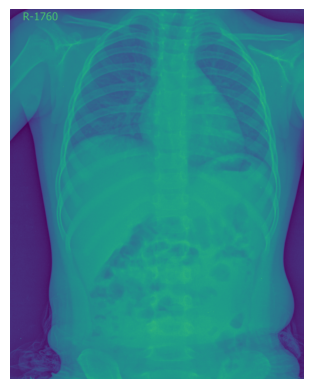

Predicted class for the image: Paediatric


In [17]:
import matplotlib.pyplot as plt
from PIL import Image
# Function to predict class for a new image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image and ensure RGB format
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image)
    
    prediction = (output.squeeze() > 0.5).float()  # Apply threshold to predict class (0 or 1)
    class_label = "Non Paediatric" if prediction.item() == 1 else "Paediatric"
    return class_label

# Test the prediction on a new image
image_path = "/home/ai-user/Abhijay/Class_dataset/pediatric/2023_11_26_9D49D672_7DB7A7E5_4BBA0F4B.jpeg"
predicted_class = predict_image(image_path)
# Open and display the image inline
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()
print(f"Predicted class for the image: {predicted_class}")


In [18]:
# Initialize variables for evaluation
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():  # No need for gradient computation during evaluation
    for images, labels in val_dataloader:  # Use your test dataloader here
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        outputs = model(images)
        preds = (outputs.squeeze() > 0.5).float()  # Threshold at 0.5 for binary classification
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

/home/ai-user/Abhijay/abhijay/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 98.39%
Precision: 0.9872
Recall: 0.9889
F1 Score: 0.9880

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1940
         1.0       0.99      0.99      0.99      3966

    accuracy                           0.98      5906
   macro avg       0.98      0.98      0.98      5906
weighted avg       0.98      0.98      0.98      5906

